# Análisis de resultados

El experimento fué realizado en un servidor de Oracle Cloud el 18 de julio del 2025 a la 1:30am (GMT-5). Debido a que es un servidor que en el día responde a solicitudes de Internet, se eligió esta hora en particular para realizar el experimento ya que es cuando el servidor recibe muy poco tráfico.

El servidor cuenta con 4 núcleos habilitados de un procesador Ampere Altra A1, de arquitectura ARM. 24GB de memoria RAM y SO _Ubuntu 24.04.2 LTS_, corriendo el kernel `6.8.0-1028-oracle`. Las versiones de los lenguajes de programación usadas en el experimento son `Python 3.12.11` y `Lua 5.4.6`

Para el análisis de resultados se optó en primera instancia por el uso de gráficas que describan los datos en los que tenemos interés, para esto se usaron las librerías `matplotlib`, `pandas` y `seaborn`.

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [17]:
python_csv = '../results/python/repeated_results.csv'
lua_csv = '../results/lua/repeated_experiment_results.csv'

df_python = pd.read_csv(python_csv)
df_lua = pd.read_csv(lua_csv)

df_python['language'] = 'Python'
df_lua['language'] = 'Lua'

# Unir ambos en un solo dataframe para análisis combinado
df = pd.concat([df_python, df_lua], ignore_index=True)

# Filtrar solo soluciones exitosas (opcional)
df_success = df[df['path_found'] == 1]

## Estadistica descriptiva
En la siguiente tabla se pueden ver la media y la mediana de los 3 algoritmos implementados en ambos lenguajes sobre el conjunto de grafos que se usó para el experimento.

In [18]:
def calcular_estadisticas(df, lenguaje='Python'):
  stats = df.groupby(['algorithm', 'graph_type',
                      'size_n'])[['time_seconds', 'cost']].agg(
                          time_mean=('time_seconds', 'mean'),
                          time_median=('time_seconds', 'median'),
                          time_std=('time_seconds', 'std'),
                          cost_mean=('cost', 'mean'),
                          cost_median=('cost', 'median'),
                          cost_std=('cost', 'std'),
                      ).reset_index()
  stats['language'] = lenguaje
  return stats


python_stats = calcular_estadisticas(df_python, lenguaje='Python')
lua_stats = calcular_estadisticas(df_lua, lenguaje='Lua')


In [19]:
tabla_comparativa = pd.concat([python_stats, lua_stats], ignore_index=True)
tabla_comparativa

,algorithm,graph_type,size_n,time_mean,time_median,time_std,cost_mean,cost_median,cost_std,language
0,Backtracking,geometric,5,0.000035,0.000033,0.000005,-1.0000,-1.0000,0.0,Python
1,Backtracking,geometric,8,0.000033,0.000030,0.000007,3.1396,3.1396,0.0,Python
2,Backtracking,geometric,10,0.000091,0.000086,0.000009,4.4327,4.4327,0.0,Python
3,Backtracking,geometric,12,0.103239,0.103295,0.000457,-1.0000,-1.0000,0.0,Python
4,Backtracking,geometric,14,0.000050,0.000047,0.000006,5.0156,5.0156,0.0,Python
...,...,...,...,...,...,...,...,...,...,...
199,NearestNeighbor,pathological,14,0.000023,0.000022,0.000004,-1.0000,-1.0000,0.0,Lua
200,NearestNeighbor,pathological,15,0.000033,0.000030,0.000006,15.0000,15.0000,0.0,Lua
201,NearestNeighbor,pathological,16,0.000041,0.000036,0.000010,-1.0000,-1.0000,0.0,Lua
202,NearestNeighbor,pathological,18,0.000035,0.000030,0.000010,-1.0000,-1.0000,0.0,Lua


## Gráfico tamaño de grafo vs tiempo

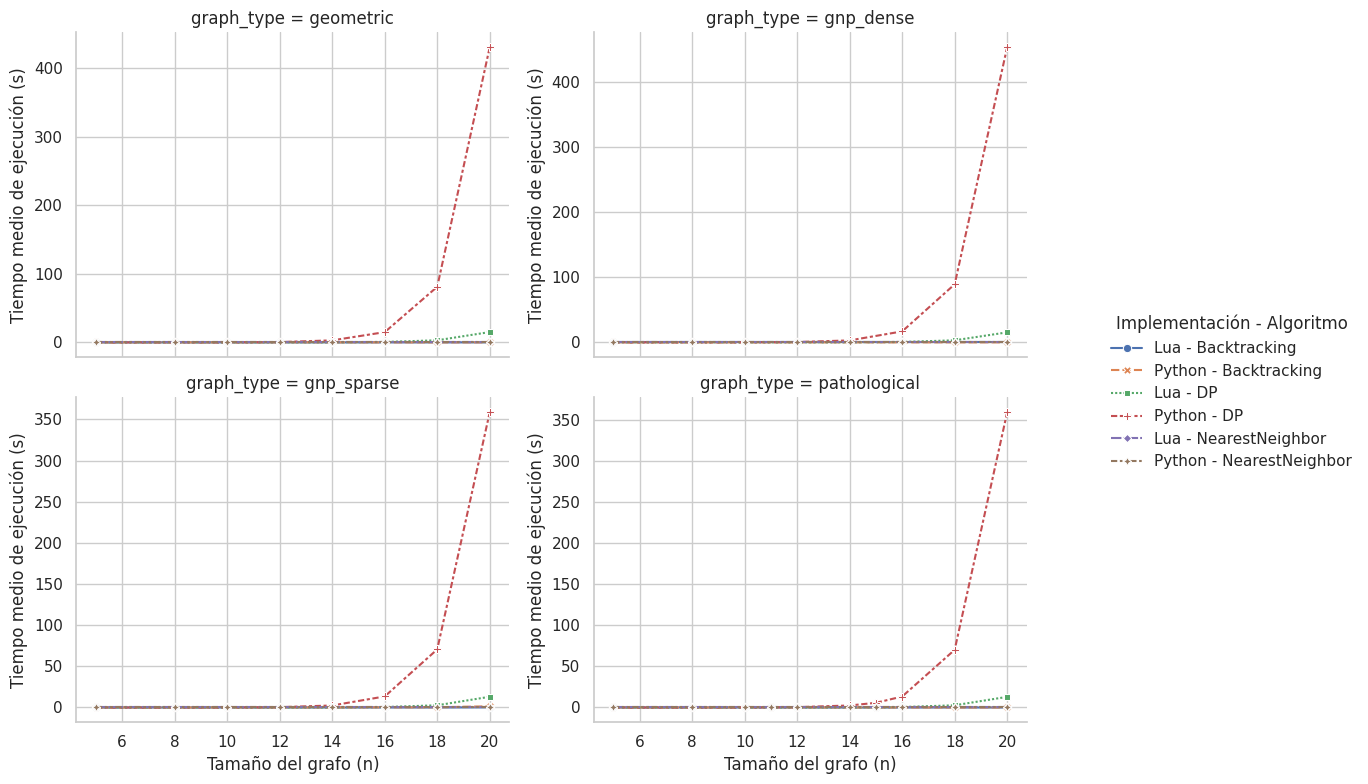

In [20]:
# Agrupar y calcular media y desviación estándar por grupo
grouped = df.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                     ]).agg(mean_time=('time_seconds', 'mean'),
                            std_time=('time_seconds', 'std')).reset_index()

# Crear columna combinada para distinguir en la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Configurar estilo
sns.set(style="whitegrid")

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar gráfico por subgráfico
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_time',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Ajustar etiquetas
for ax in g.axes.flat:
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Tiempo medio de ejecución (s)')

# Ajustar leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 1. Gráfico tamaño de grafo vs tiempo (escala normal)*

A partir del análisis de la gráfica, se observa que el algoritmo de Programación Dinámica (DP), especialmente en Python, muestra un crecimiento exponencial del tiempo. En contraste, el mismo algoritmo implementado en Lua muestra crecimiento, pero no de manera exagerada como lo hace en Python. El tiempo de ejecución de los algoritmos en ambos lenguajes fué muy diferente, mientras que Lua realizó todas las pruebas en 5 min 56 s, Python las realizó en 2 h 46 min 06 s, siendo aproximadamente 30 veces mas lento con respecto a Lua.

En esta escala los algoritmos de Vecino Más Cercano (Nearest Neighbor) y Backtracking parecen ser constantes, sin embargo, para poder hacer un mejor estudio de los resultados se optó por ver los datos en escala logarítmica en el eye $y$.

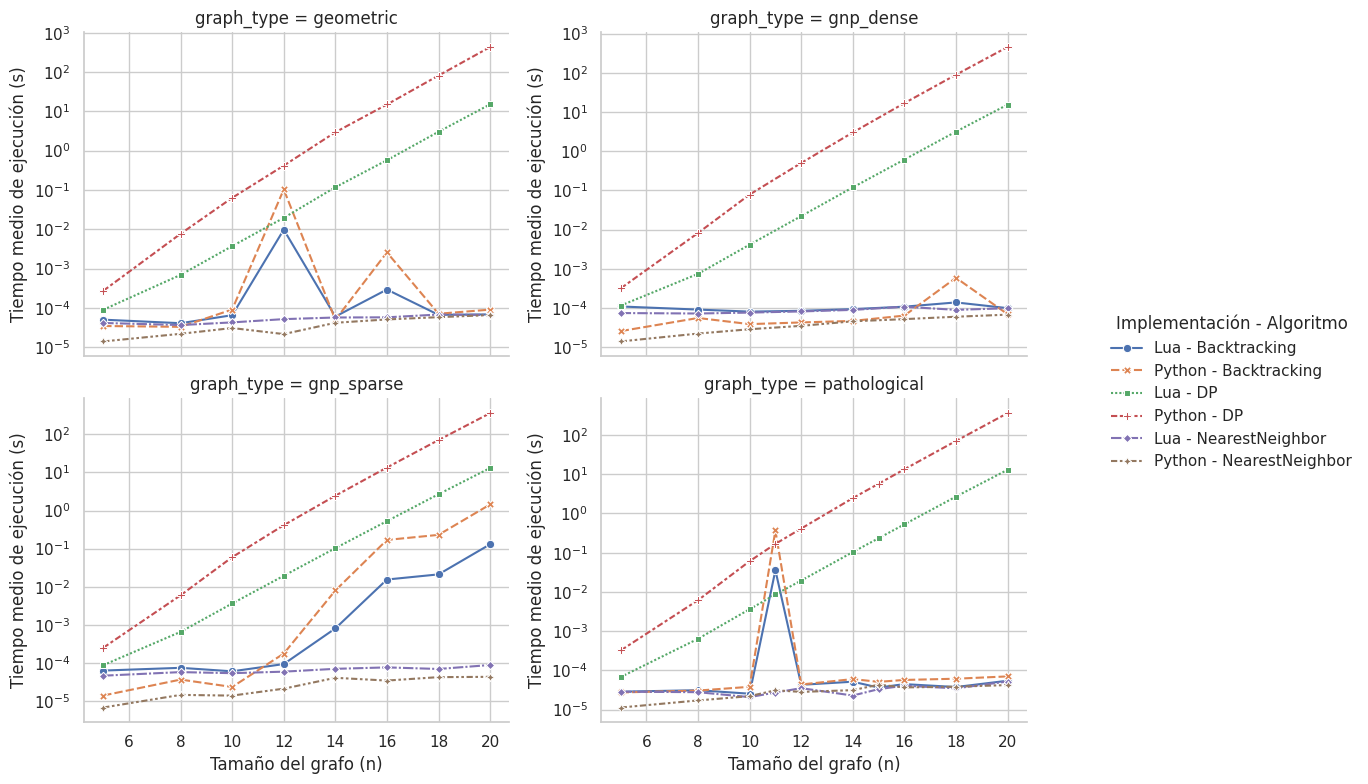

In [21]:
# Agrupar y calcular media y desviación estándar por grupo
grouped = df.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                     ]).agg(mean_time=('time_seconds', 'mean'),
                            std_time=('time_seconds', 'std')).reset_index()

# Crear columna combinada para distinguir en la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar gráfico por subgráfico
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_time',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Ajustar escala logarítmica y etiquetas
for ax in g.axes.flat:
  ax.set_yscale('log')
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Tiempo medio de ejecución (s)')

# Ajustar leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 2. Gráfico tamaño de grafo vs tiempo (escala logarítmica)*

En términos de rendimiento, el algoritmo del vecino más cercano (Nearest Neighbor) demuestra ser el más eficiente en cuanto a tiempo de ejecución, tanto en Lua como en Python. Esto se evidencia en ambas gráficas —en escala normal y logarítmica— donde las curvas asociadas a este algoritmo se mantienen prácticamente planas a medida que aumenta el tamaño del grafo, indicando un crecimiento casi constante del tiempo. Este comportamiento sugiere una baja complejidad computacional (aproximadamente cuadrática), lo que lo hace adecuado para instancias de mayor tamaño. Por otro lado, en la gráfica logarítmica se observan picos anómalos en los tiempos de ejecución de los algoritmos de Backtracking y Programación Dinámica en los grafos de tipo geométrico y patológico. Estos picos podrían deberse a una combinación de factores, como la estructura específica de estos grafos que desencadena casos especialmente desfavorables para dichos algoritmos, o también a efectos de variabilidad en la ejecución (como la fragmentación de memoria o la planificación de procesos por el sistema operativo). Este comportamiento errático contrasta con la regularidad de Nearest Neighbor y evidencia la sensibilidad de los algoritmos exactos frente a la topología del grafo.

También se evidencia que Lua tiende a tener un desempeño más eficiente en DP y Backtracking en comparación con su contraparte en Python, aunque la diferencia no siempre es significativa en grafos con pocos vértices.

Finalmente, estas dos gráficas expresan:

- En Nearest Neighbor, el tiempo de ejecución crece de forma muy lenta o casi constante, lo cual es característico de algoritmos heurísticos con baja complejidad.
- En cambio, en DP y Backtracking, el tiempo crece muy rápidamente con el tamaño del grafo (debido a su complejidad exponencial o pseudopolinomial), lo que los vuelve poco prácticos para grafos medianos o grandes.

Estas observaciones permiten inferir que, para instancias grandes o en contextos donde el rendimiento es crítico, el uso de heurísticas como Vecino Más Cercano resulta más conveniente, mientras que las soluciones exactas deben reservarse para grafos pequeños debido a su alta complejidad computacional.

## Gráfico tamaño de grafo vs costo

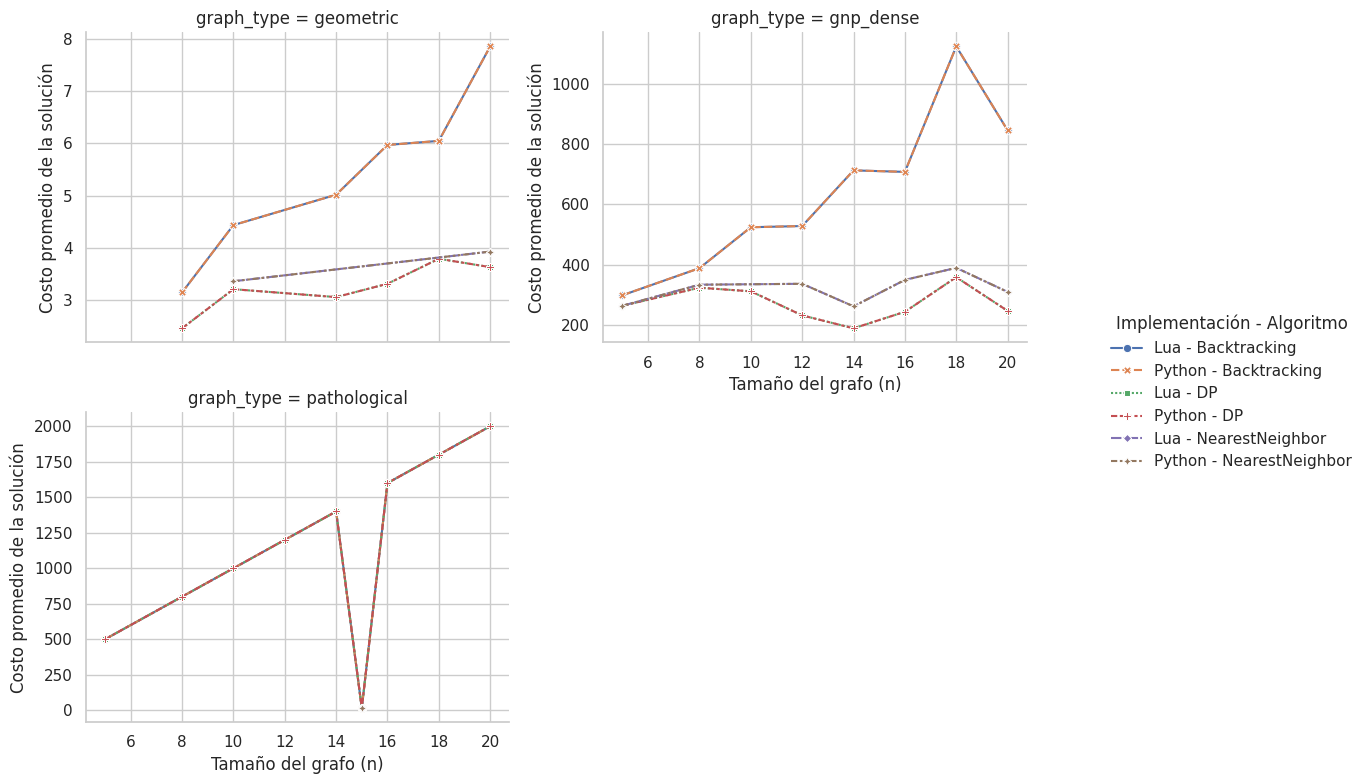

In [22]:
# Agrupar y calcular estadísticas
grouped = df_success.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                             ]).agg(mean_cost=('cost', 'mean'),
                                    std_cost=('cost', 'std')).reset_index()

# Etiqueta para la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Graficar líneas con barras de error
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_cost',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Etiquetas y ajustes
for ax in g.axes.flat:
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Costo promedio de la solución')

g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 3: Gráfico tamaño de grafo vs costo*

En los grafos geométricos, se observa que el algoritmo Nearest Neighbor obtiene soluciones consistentemente más baratas que Backtracking y DP a medida que crece el tamaño del grafo. Esto puede atribuirse a la propiedad espacial de los grafos geométricos, donde las conexiones más cortas tienden a ser locales y el recorrido "greedy" del vecino más cercano resulta más efectivo.

Para los grafos gnp_dense, el comportamiento es más variado. Aunque el algoritmo Nearest Neighbor sigue ofreciendo costos relativamente bajos, su ventaja frente a Backtracking y DP se reduce. Esto es razonable, ya que en grafos densos los caminos óptimos pueden ser más difíciles de aproximar mediante decisiones locales.

Sin embargo, el comportamiento más llamativo se presenta en los grafos patológicos. Aquí, se observa un aumento lineal del costo promedio de la solución con el tamaño del grafo tanto para Backtracking como para DP. Pero lo más notable es la ausencia total de curvas correspondientes al algoritmo Nearest Neighbor. 

Dado que el grafo patológico está diseñado para generar los peores casos para heurísticas simples, Nearest Neighbor no fue capaz de encontrar soluciones válidas o razonables, lo que pondría en evidencia su limitación frente a estructuras adversas. Esta omisión refuerza la importancia de elegir algoritmos robustos cuando se enfrentan instancias patológicas o diseñadas con trampas específicas.

## Radio de Aproximación Nearest Neighbor vs DP

In [23]:
# Filtramos solo los datos de Python (o Lua)
df = df_python.copy()  # o df_lua

# Filtrar las filas relevantes
df_filtered = df[df['algorithm'].isin(['DP', 'NearestNeighbor'])]

# Asegurarse de que solo consideramos soluciones exitosas (path_found == 1)
df_success = df_filtered[df_filtered['path_found'] == 1]

# Agrupar por instancia (para comparar algoritmo óptimo vs heurístico)
pivot = df_success.pivot_table(
    index=['instance_name', 'graph_type', 'size_n', 'run_id'],
    columns='algorithm',
    values='cost').reset_index()

# Eliminar filas donde no hay solución DP o heurística
pivot = pivot.dropna(subset=['DP', 'NearestNeighbor'])

# Calcular el ratio de aproximación (heurístico / óptimo)
pivot['approx_ratio'] = pivot['NearestNeighbor'] / pivot['DP']

approx_summary = pivot.groupby(['graph_type', 'size_n'
                               ])['approx_ratio'].agg(['mean']).reset_index()
approx_summary.rename(columns={'mean': 'ratio_mean'}, inplace=True)

approx_summary


,graph_type,size_n,ratio_mean
0,geometric,10,1.047555
1,geometric,20,1.082237
2,gnp_dense,5,1.000000
3,gnp_dense,8,1.030960
4,gnp_dense,12,1.454545
5,gnp_dense,14,1.388298
6,gnp_dense,16,1.436214
7,gnp_dense,18,1.086592
8,gnp_dense,20,1.256098
9,pathological,15,1.000000


_Tabla 1. Radio de Aproximación_

En ésta tabla es posible apreciar la calidad de los resultados obtenidos por el algoritmo heurístico a comparación del exacto. Nótese que el algoritmo Nearest Neighbor solo encontró Ciclos Hamiltonianos en **10** grafos, el estudio en total contenía **34** grafos.

Se encuentra usando $\frac{CostoNearestNeighbor}{CostoÓptimoDP}$ ya que lo ideal es encontrar el ciclo con el costo más bajo posible (problema de optimización).

_Recordar que este número debe ser cercano a 1_

### Gráfico tamaño de grafo vs costo (Comparación DP y NN)

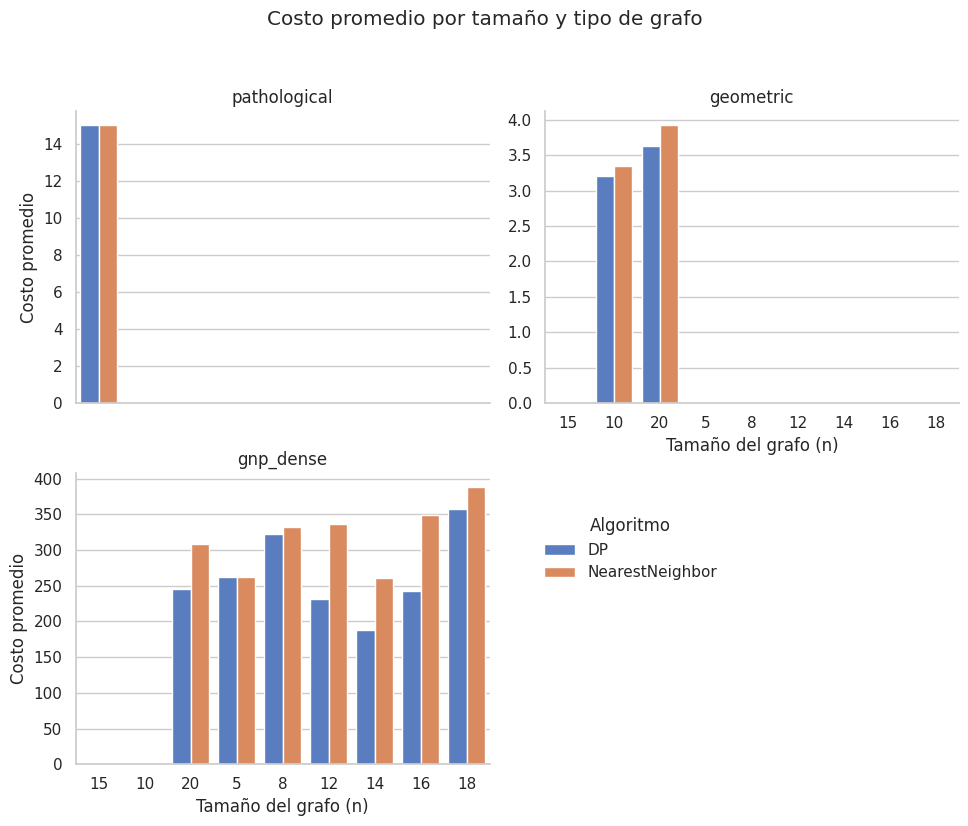

In [24]:
melted_costs = pivot.melt(id_vars=['graph_type', 'size_n'],
                          value_vars=['DP', 'NearestNeighbor'],
                          var_name='algorithm',
                          value_name='cost')

# FacetGrid para generar un gráfico por tipo de grafo
g = sns.FacetGrid(melted_costs,
                  col='graph_type',
                  col_wrap=2,
                  height=4,
                  sharey=False)

# Mapeamos un gráfico de barras
g.map_dataframe(sns.barplot,
                x='size_n',
                y='cost',
                hue='algorithm',
                palette='muted',
                errorbar='sd')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Costo promedio")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Algoritmo", bbox_to_anchor=(0.75, 0.3), loc='lower right')
plt.suptitle("Costo promedio por tamaño y tipo de grafo", y=1.03)
plt.tight_layout()
plt.show()

_Figura 4. Gráfico tamaño de grafo vs costo (Comparación DP y NN)_

La estrategia heurística encontró ciclos más costosos a comparación de los valores óptimos dados por la estrategia de Programación Dinámica.

## Gráfica radio de aproximación vs tamaño de grafo

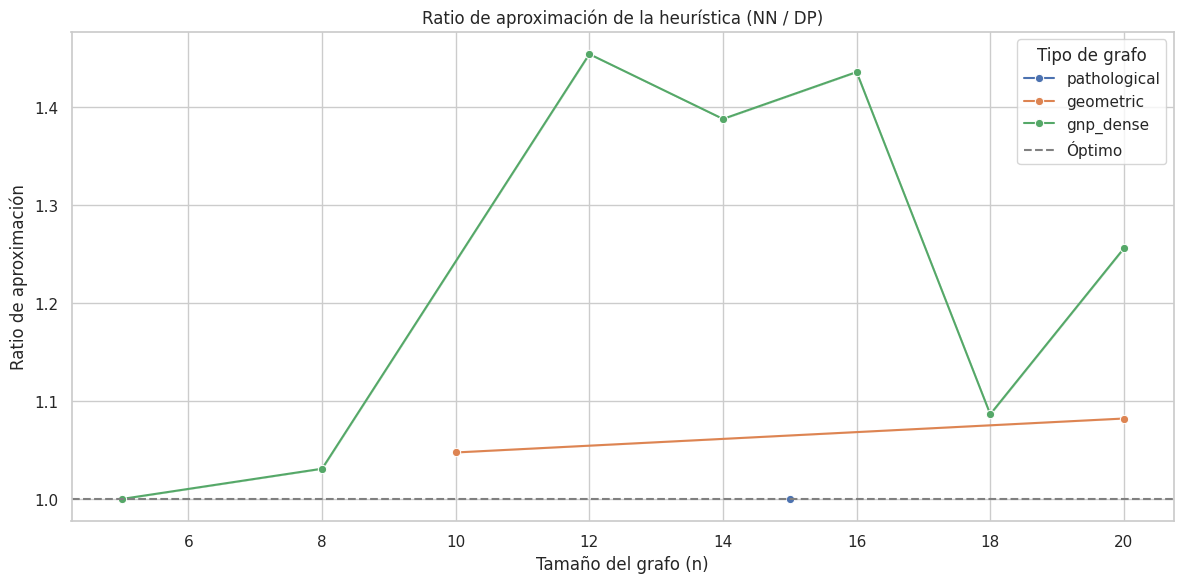

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot,
             x='size_n',
             y='approx_ratio',
             hue='graph_type',
             marker='o')
plt.axhline(1.0, color='gray', linestyle='--', label='Óptimo')
plt.title('Ratio de aproximación de la heurística (NN / DP)')
plt.xlabel('Tamaño del grafo (n)')
plt.ylabel('Ratio de aproximación')
plt.legend(title='Tipo de grafo')
plt.tight_layout()
plt.show()

_Figura 5. Gráfico radio de aproximación vs tamaño de grafo (discriminado por tipo de grafo)_

Esta gráfica permite apreciar de una mejor manera los resultados obtenidos en la _Tabla 1._

### Análisis por tipo de grafo:
1. `geometric`

- La línea naranja muestra un crecimiento muy leve del ratio, desde aproximadamente 1.04 hasta 1.08 a medida que aumenta el tamaño del grafo.

- Interpretación: El comportamiento espacial de estos grafos favorece a la heurística NN, ya que los nodos más cercanos suelen ser buenas elecciones locales. La cercanía geográfica reduce la posibilidad de tomar decisiones muy subóptimas.

- Conclusión: Nearest Neighbor es razonablemente confiable en este tipo de grafos.

2. `gnp_dense`

- La línea verde presenta una gran variabilidad con picos notorios: el ratio se eleva hasta aproximadamente 1.46 para $n = 12$ y luego vuelve a caer abruptamente en $n = 18$, antes de subir nuevamente en $n = 20$.

- Interpretación: En grafos densos aleatorios, donde hay muchas conexiones posibles, las decisiones locales de NN pueden ser muy malas globalmente. Los picos indican casos en los que la heurística se desvía significativamente del óptimo, probablemente por "ciclos tempranos" o malas decisiones iniciales.

- Conclusión: NN tiene un comportamiento muy inestable en estos grafos, y aunque ocasionalmente se acerca al óptimo, en general no es confiable.

3. `pathological`

- La línea azul aparece solo para $n = 15$, con un ratio exacto de 1.0.

- Interpretación: Esto sugiere que en esa instancia puntual, NN encontró por casualidad una solución óptima (o el grafo fue diseñado de forma que las decisiones locales sí llevaban al camino óptimo). La ausencia de más datos refuerza la idea de que NN falla completamente en otras instancias patológicas, posiblemente no generando caminos válidos.

- Conclusión: La heurística NN es extremadamente vulnerable a grafos diseñados para sabotear estrategias greedy. La ausencia de datos en la mayoría de los puntos es evidencia de fallos sistemáticos.

### Conclusión general
- NN es eficiente y efectiva en grafos geométricos.
- Es muy variable en grafos densos aleatorios, y puede entregar resultados bastante alejados del óptimo.
- En grafos patológicos, su desempeño es inaceptable o nulo, lo cual subraya la importancia de tener una heurística más robusta cuando se espera enfrentar instancias adversas.

## Tasa de éxito estrategia heurística

In [26]:
# Paso 1: Filtrar solo las filas relevantes
dp = df[df['algorithm'] == 'DP'][[
    'instance_name', 'graph_type', 'size_n', 'path_found'
]]
nn = df[df['algorithm'] == 'NearestNeighbor'][['instance_name', 'path_found']]
nn = nn.rename(columns={'path_found': 'nn_path_found'})

# Paso 2: Hacer merge por instancia
merged = pd.merge(dp, nn, on='instance_name', how='inner')

# Paso 3: Calcular en qué casos DP encontró solución y la heurística no
merged['dp_ok_nn_fail'] = (merged['path_found']
                           == True) & (merged['nn_path_found'] == False)

# Paso 4: Agrupar por tipo de grafo y tamaño
relative_failures = (merged.groupby(['graph_type', 'size_n']).agg(
    total_dp_success=('path_found', 'sum'),
    nn_failures_on_dp_success=('dp_ok_nn_fail', 'sum')).assign(
        failure_rate=lambda x: 100 * x['nn_failures_on_dp_success'] / x[
            'total_dp_success'],
        relative_success_rate=lambda x: 100 -
        (100 * x['nn_failures_on_dp_success'] / x['total_dp_success'])).
                     reset_index())

relative_failures


,graph_type,size_n,total_dp_success,nn_failures_on_dp_success,failure_rate,relative_success_rate
0,geometric,5,0,0,NaN,NaN
1,geometric,8,25,25,100.0,0.0
2,geometric,10,25,0,0.0,100.0
3,geometric,12,0,0,NaN,NaN
4,geometric,14,25,25,100.0,0.0
5,geometric,16,25,25,100.0,0.0
6,geometric,18,25,25,100.0,0.0
7,geometric,20,25,0,0.0,100.0
8,gnp_dense,5,25,0,0.0,100.0
9,gnp_dense,8,25,0,0.0,100.0


_Tabla 2. Tasa de éxito estrategia heurística_

Se hizo esta medición usando
$\frac{InstanciasNNEncontróCiclo}{InstanciasDPEncontróCiclo}$

## Gráfico tasa de éxito estrategia heurística por tipo y tamaño de grafo

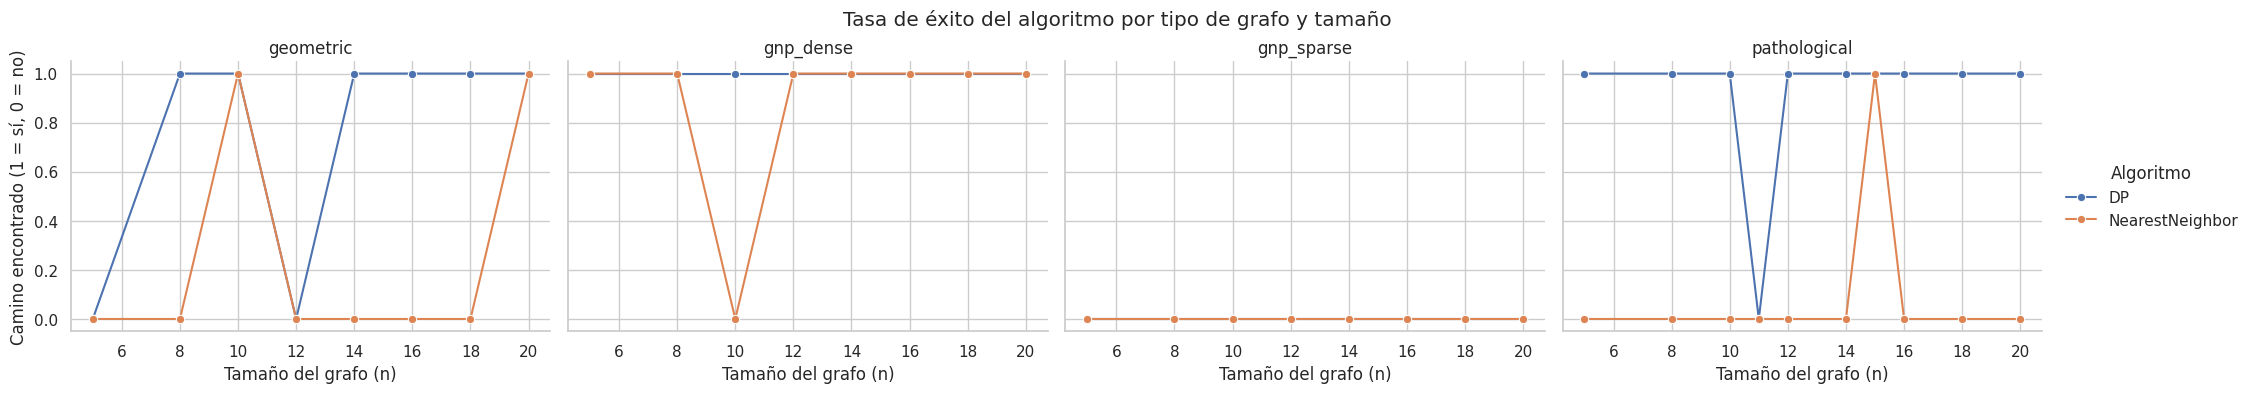

In [27]:
# Asegurar que los datos estén en el formato correcto
long_df = merged.melt(id_vars=['graph_type', 'size_n'],
                      value_vars=['path_found', 'nn_path_found'],
                      var_name='algorithm',
                      value_name='path_found_binary')

long_df['algorithm'] = long_df['algorithm'].map({
    'path_found': 'DP',
    'nn_path_found': 'NearestNeighbor'
})
long_df['path_found_binary'] = long_df['path_found_binary'].astype(int)

# Agrupar para tasa de éxito
summary = (long_df.groupby(['algorithm', 'graph_type', 'size_n'
                           ])['path_found_binary'].mean().reset_index())

# Crear subgráficas por tipo de grafo
g = sns.FacetGrid(summary,
                  col='graph_type',
                  hue='algorithm',
                  height=4,
                  aspect=1.3,
                  sharey=True)

g.map_dataframe(sns.lineplot, x='size_n', y='path_found_binary', marker='o')

g.set_axis_labels("Tamaño del grafo (n)", "Camino encontrado (1 = sí, 0 = no)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.set(ylim=(-0.05, 1.05))

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Tasa de éxito del algoritmo por tipo de grafo y tamaño")
plt.show()

_Figura 6. Gráfico tasa de éxito estrategia heurística por tipo y tamaño de grafo_

La gráfica muestra la tasa de éxito de los algoritmos Nearest Neighbor (NN) y Programación Dinámica (DP) para encontrar un ciclo hamiltoniano completo (TSP) en diferentes tipos de grafos y tamaños $n. El $eje $y$ indica si se encontró un camino válido

### Análisis por tipo de grafo:
1. `geometric`

- DP (azul) encuentra siempre una solución para $n\geq$ 8.

- NN (naranja) tiene un comportamiento alternante: falla en $n = 5,8,12,14,16,18$, pero acierta en $n = 10, 20$.

- Interpretación: Aunque el grafo geométrico favorece a las decisiones locales, NN a veces se encierra prematuramente o no logra cerrar el ciclo. Esto muestra que su tasa de éxito es inconsistente.

2. `gnp_dense`

- DP (azul) tiene éxito constante.

- NN falla únicamente en $n = 10$.

- Interpretación: En grafos densos, es muy probable que existan caminos hamiltonianos completos, por lo que NN generalmente tiene éxito, salvo casos donde el ordenamiento local lo lleva a callejones sin salida. El error puntual en $n = 10$ podría deberse a una mala elección inicial o a un subgrafo problemático.

3. `gnp_sparse`

- DP falla en todos los tamaños.

- NN también falla siempre.

- Interpretación: Este tipo de grafo, por ser ralo, tiene alta probabilidad de no contener un ciclo hamiltoniano completo. Esto limita ambos algoritmos, no porque fallen computacionalmente, sino porque el problema no tiene solución en esos casos.

4. `pathological`

- DP resuelve correctamente todos los casos menos $n = 11$.

- NN solo tiene éxito en $n = 15$.

- Interpretación: Los grafos patológicos están diseñados para sabotear estrategias greedy como NN. El único éxito puntual de NN en $n = 15$ parece un caso accidental. Por su parte, la falla de DP en $n = 11$ podría deberse a una implementación o una instancia no resoluble, aunque es raro.

## Gráfico uso de memoria por tipo de grafo (Python)
Es necesario aclarar que, aunque se hayan hecho mediciones de uso de memoria de los algoritmos en Lua, este lenguaje no dispone de un medidor robusto como si lo tiene Python con `tracemalloc`. Lua hizo las mediciones comparando la memoria que estaba en uso por el recolector de basura antes y después de cada algoritmo, introduciendo así ruido en los resultados. Debido a ello, se excluyeron los resultados de Lua para estas gráficas en particular.

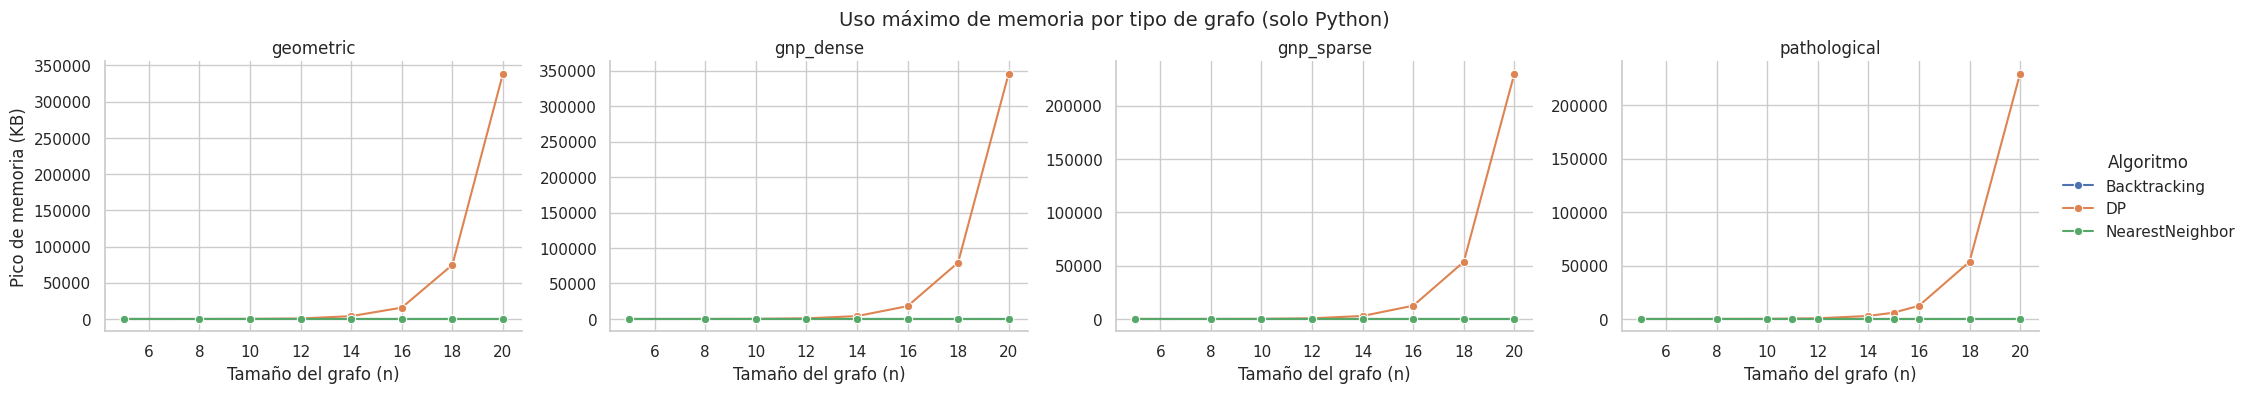

In [28]:
# Agrupar por tamaño, tipo de grafo y algoritmo
grouped = (df_python.groupby(['graph_type', 'algorithm',
                              'size_n'])['memory_peak_kb'].mean().reset_index())

# Crear FacetGrid por tipo de grafo
g = sns.FacetGrid(grouped,
                  col="graph_type",
                  hue="algorithm",
                  height=4,
                  aspect=1.3,
                  sharey=False)

# Graficar líneas
g.map_dataframe(sns.lineplot, x='size_n', y='memory_peak_kb', marker='o')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Pico de memoria (KB)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.fig.suptitle("Uso máximo de memoria por tipo de grafo (solo Python)",
               fontsize=14)
plt.subplots_adjust(top=0.85)

plt.show()

_Figura 7. Gráfico uso de memoria por tipo de grafo (escala normal)_

La gráfica muestra el uso máximo de memoria (en KB) para los tres algoritmos aplicados a distintos tipos de grafos a medida que crece el tamaño del grafo $n$. En esta escala no se percibe el uso de memoria de Backtracking, el cual resulta ser muy similar al de NN, más adelante en escala logarítmica se podrá hacer un mejor análisis.

### Análisis por tipo de grafo:

1. `geometric`

* Nearest Neighbor (verde): uso de memoria constante y muy bajo.
* DP (naranja): el consumo crece exponencialmente a partir de $n = 14$, alcanzando más de 300,000 KB en $n = 20$.

2. `gnp_dense`

* NN mantiene su perfil eficiente de uso de memoria.
* DP vuelve a mostrar un crecimiento explosivo y sostenido con el tamaño del grafo, aunque un poco más controlado que en el caso geométrico.
* Interpretación: En grafos densos, donde hay muchas conexiones, la cantidad de subproblemas que DP debe almacenar también crece rápidamente, elevando el uso de memoria.

3. `gnp_sparse`

* NN sigue con uso constante y bajo.
* DP escala de forma similar: estable hasta $n = 14$, luego se dispara.
* Observación importante: Aunque los grafos escasos no tienen muchas aristas, la representación y evaluación de subconjuntos sigue siendo costosa para DP, lo que explica el alto uso de memoria.

4. `pathological`

* NN se mantiene eficiente.
* DP repite el patrón explosivo, alcanzando picos altos de uso de memoria.
* Interpretación: Este tipo de grafo presenta una estructura difícil que obliga a DP a conservar múltiples rutas parciales para evaluar, y por tanto, consumir más espacio.

###  Conclusiones generales

| Algoritmo                  | Uso de memoria                                       | Escalabilidad | Observaciones                                  |
| -------------------------- | ---------------------------------------------------- | ------------- | ---------------------------------------------- |
| Nearest Neighbor           | Muy bajo y constante                                 | Excelente     | Ideal en entornos con restricciones de memoria |
| Programación Dinámica (DP) | Exponencial desde $n = 14$                           | Limitada      | Solo viable para tamaños pequeños o medianos   |
| Backtracking               | No aparece (dado a la escala del eje $y$) | N/A      | N/A          |

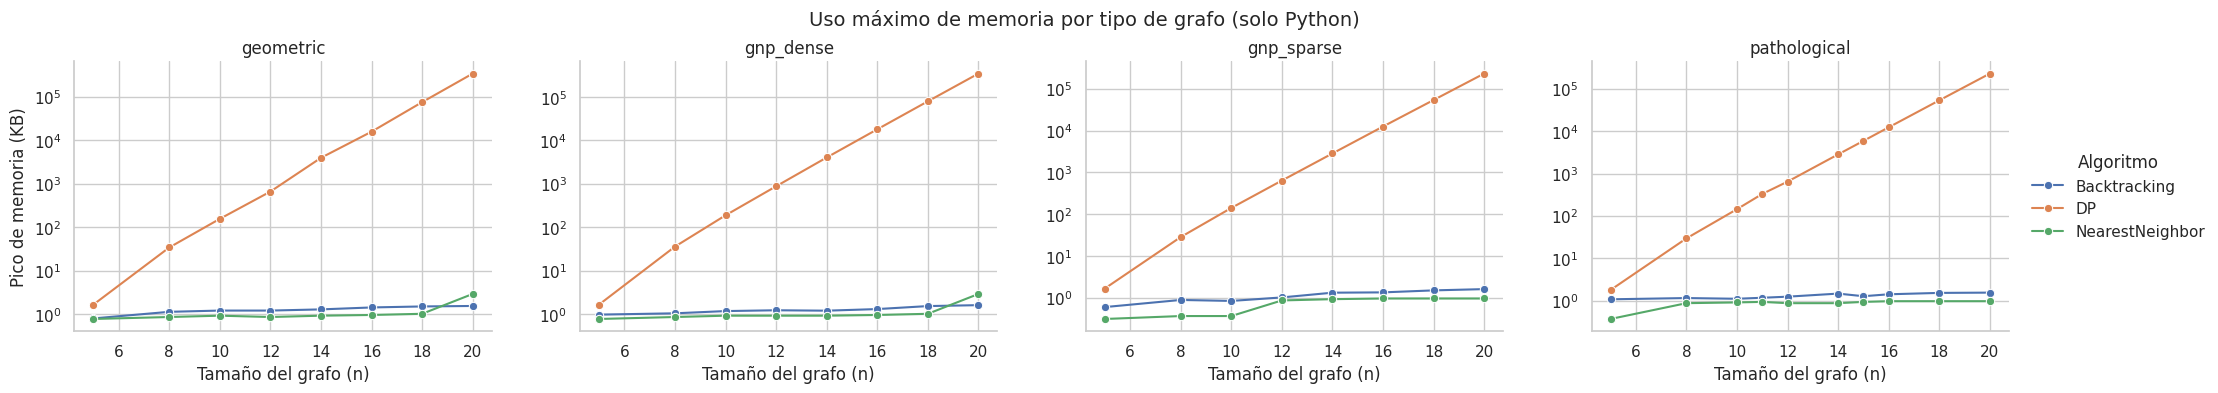

In [29]:
# Agrupar por tamaño, tipo de grafo y algoritmo
grouped = (df_python.groupby(['graph_type', 'algorithm',
                              'size_n'])['memory_peak_kb'].mean().reset_index())

# Crear FacetGrid por tipo de grafo
g = sns.FacetGrid(grouped,
                  col="graph_type",
                  hue="algorithm",
                  height=4,
                  aspect=1.3,
                  sharey=False)

# Graficar líneas
g.map_dataframe(sns.lineplot, x='size_n', y='memory_peak_kb', marker='o')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Pico de memoria (KB)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.set(yscale='log')
g.fig.suptitle("Uso máximo de memoria por tipo de grafo (solo Python)",
               fontsize=14)
plt.subplots_adjust(top=0.85)

plt.show()

_Figura 8. Gráfico uso de memoria por tipo de grafo (escala logarítmica)_

En esta gráfica se observan con mayor claridad los patrones de escalabilidad en términos de consumo de memoria.

###  Lectura clave de la gráfica logarítmica

1. Programación Dinámica (DP - Naranja)

* Comportamiento claramente exponencial: en todos los tipos de grafo, la curva de DP sigue una línea recta ascendente en escala logarítmica, lo que implica crecimiento exponencial con respecto al tamaño del grafo $n$.
* Dominio absoluto del uso de memoria: para $n = 20$, DP supera ampliamente a los otros algoritmos.

2. Backtracking (Azul)

* Crecimiento bajo pero no constante con ligeros incrementos según el grafo y tamaño.
* Ligera diferencia entre tipos de grafo: en `gnp_sparse`, Backtracking parece crecer más notoriamente, probablemente debido a mayor variabilidad en rutas posibles por la estructura dispersa.

3. Nearest Neighbor (Verde)

* Comportamiento plano: uso de memoria constante en todos los casos. Esto confirma su perfil altamente eficiente en cuanto a memoria.
* Ligero incremento en `geometric` para $n = 20$, pero aún sigue siendo despreciable en comparación con los otros algoritmos.

###  Comparación por tipo de grafo

| Tipo de grafo | DP (Naranja) | Backtracking (Azul) | Nearest Neighbor (Verde)       |
| ------------- | ------------ | ------------------- | ------------------------------ |
| Geometric     | Exponencial  | Lento y estable     | Constante, leve pico en $n=20$ |
| gnp\_dense    | Exponencial  | Mínimo crecimiento  | Constante                      |
| gnp\_sparse   | Exponencial  | Más variable        | Constante                      |
| pathological  | Exponencial  | Ligeramente mayor   | Constante                      |

### Conclusiones finales (gráfica logarítmica)

* DP es insostenible en memoria para $n > 16$, incluso en grafos simples.
* Backtracking es viable en memoria, pero no necesariamente en tiempo.
* Nearest Neighbor es el algoritmo más liviano en consumo de recursos, ideal para grandes $n$, aunque sacrifica calidad de solución.

# Conclusiones generales del experimento

1. Resumen de los Hallazgos Principales

A partir del análisis experimental de los algoritmos Programación Dinámica (DP), Backtracking y Vecino Más Cercano (Nearest Neighbor), se identificaron los siguientes hallazgos clave:

* **Vecino Más Cercano** es el algoritmo más rápido. Su tiempo de ejecución es considerablemente menor y su uso de memoria es constante o marginalmente creciente para todos los tipos de grafos.
* **Programación Dinámica** garantiza la solución óptima, pero presenta un crecimiento exponencial en tiempo de ejecución y consumo de memoria RAM, especialmente notorio en grafos patológicos y geométricos.
* **Backtracking** ofrece un compromiso intermedio: tiempos de ejecución y consumo de memoria más contenidos que DP, pero sin garantizar la optimalidad.

2. Discusión de Implicaciones

Los resultados sugieren que la selección del algoritmo debe depender del contexto de aplicación:

* Usar **Programación Dinámica** cuando la solución óptima sea crítica y el problema tenga una dimensión pequeña a mediana (hasta $n \approx 20$). Requiere consideración especial del alto consumo de memoria.
* Usar **Vecino Más Cercano** en problemas de gran escala o en tiempo real donde una solución aproximada pero rápida es suficiente. Es el algoritmo más eficiente en recursos.
* Usar **Backtracking** como referencia base, o cuando se desea una solución determinista en grafos pequeños con menor complejidad de implementación que DP.

3. Limitaciones del Estudio

* Las mediciones fueron realizadas en un servidor público que recibe tráfico de Internet constante, lo cual introduce overhead adicional en tiempo y memoria.
* El tamaño de los grafos se limitó a $n \leq 20$, por lo que los resultados no pueden extrapolarse directamente a aplicaciones industriales.
* Los grafos utilizados fueron generados aleatoriamente según distribuciones específicas (`geometric`, `gnp_dense`, `gnp_sparse`, `pathological`), y pueden no reflejar estructuras reales.
* No se consideraron variantes mejoradas de los algoritmos (por ejemplo, heurísticas híbridas).

4. Trabajo Futuro

* Incorporar algoritmos heurísticos avanzados como Simulated Annealing, Algoritmos Genéticos o Ant Colony Optimization para comparar rendimiento.
* Realizar pruebas con grafos reales provenientes de aplicaciones logísticas, redes o bioinformática.
* Ampliar el rango de análisis a valores mayores de $n$ y evaluar en lenguajes compilados.
* Explorar estructuras de grafos adicionales, incluyendo grafos dirigidos, ponderados negativamente o con restricciones espaciales.
